<a href="https://colab.research.google.com/github/Pratyushanand26/WiDS_5.0/blob/main/week4/week4_wavenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2026-02-01 14:15:41--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2026-02-01 14:15:42 (11.8 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [17]:
words = open('names.txt', 'r').read().splitlines()
print(f"Total words: {len(words)}")
print(words[:8])

Total words: 32033
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [18]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(f"Vocab size: {vocab_size}")

Vocab size: 27


In [19]:
block_size = 8

def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,  Yte  = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [20]:
class FlattenConsecutive(torch.nn.Module):
    def __init__(self, n):
        super().__init__()
        self.n = n

    def forward(self, x):
        B, T, C = x.shape
        x = x.reshape(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        return x

class BatchNorm1d(torch.nn.BatchNorm1d):
    def forward(self, x):
        if x.dim() == 2:
            return super().forward(x)

        x = x.permute(0, 2, 1)
        x = super().forward(x)
        x = x.permute(0, 2, 1)
        return x

In [21]:
torch.manual_seed(42)

n_embd = 24
n_hidden = 128

model = torch.nn.Sequential(
    torch.nn.Embedding(vocab_size, n_embd),

    FlattenConsecutive(2),
    torch.nn.Linear(n_embd * 2, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    torch.nn.Tanh(),

    FlattenConsecutive(2),
    torch.nn.Linear(n_hidden * 2, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    torch.nn.Tanh(),

    FlattenConsecutive(2),
    torch.nn.Linear(n_hidden * 2, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    torch.nn.Tanh(),

    torch.nn.Linear(n_hidden, vocab_size),
)

with torch.no_grad():
  model[-1].weight *= 0.1

parameters = [p for p in model.parameters()]
print(f"Total Parameters: {sum(p.nelement() for p in parameters)}")
for p in parameters:
  p.requires_grad = True

Total Parameters: 76579


In [22]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # Minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # Forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3111
  10000/ 200000: 1.8829
  20000/ 200000: 1.6790
  30000/ 200000: 2.0373
  40000/ 200000: 2.2189
  50000/ 200000: 1.8329
  60000/ 200000: 2.3416
  70000/ 200000: 1.6909
  80000/ 200000: 1.6500
  90000/ 200000: 1.7834
 100000/ 200000: 2.1357
 110000/ 200000: 2.1561
 120000/ 200000: 1.6567
 130000/ 200000: 1.9405
 140000/ 200000: 2.0889
 150000/ 200000: 2.1164
 160000/ 200000: 2.2954
 170000/ 200000: 1.7657
 180000/ 200000: 1.8138
 190000/ 200000: 2.0672


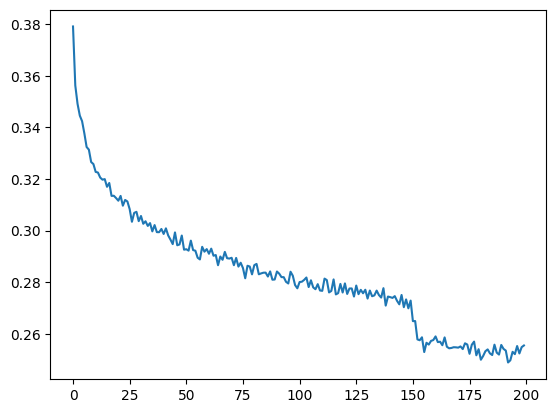

In [23]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [24]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.764427661895752
val 1.9900486469268799


In [27]:
for _ in range(20):
    out = []
    context = [0] * block_size
    model.eval()
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    print(''.join(itos[i] for i in out))
    model.train()

brandleigh.
kadan.
cobaid.
kendryx.
haunanda.
yazmin.
aorynn.
elvinah.
baylee.
arthane.
starthikuse.
kyannah.
runirah.
taite.
kaisley.
gabria.
tori.
sanny.
quinl.
idel.
